### Convert the polygons from the solar plants to coordinates which can be used at google maps.

1. Open large satellite image and match it with the polygons from the solar plants (trainings data).
2. Convert the polygons to coordinates. (to check if this is working)
3. Cut the large satellite image into smaller images and save them in a folder, but keep the coordinates of the image.
4. Use additional padding on all bands only using numpy
5. Get size of each mask in image patch (count pixels or use the polygon)

In [1]:
import rasterio
from rasterio import plot
from rasterio.plot import show
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np
import os
import re
from typing import Any, Dict, Tuple, Union

#### 1. Open large satellite image and match it with the polygons from the solar plants (trainings data).

In [2]:
image_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\raw_sentinel_download\S2A_MSIL2A_20230208T103211_N0509_R108_T32UNA_20230208T164302.SAFE\GRANULE\L2A_T32UNA_A039859_20230208T103552\IMG_DATA\R10m\T32UNA_20230208T103211_TCI_10m.jp2")
trn_polygons_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\raw_data\trn_polygons.geojson")

In [3]:
image = rasterio.open(image_path)

In [4]:
trn_polygons = gpd.read_file(trn_polygons_path)

In [5]:
if trn_polygons.crs != image.crs:
    trn_polygons = trn_polygons.to_crs(image.crs)

In [6]:
image.bounds

BoundingBox(left=499980.0, bottom=5490240.0, right=609780.0, top=5600040.0)

In [7]:
# select polygons which are inside the image 
image_polygons = trn_polygons.clip(image.bounds)

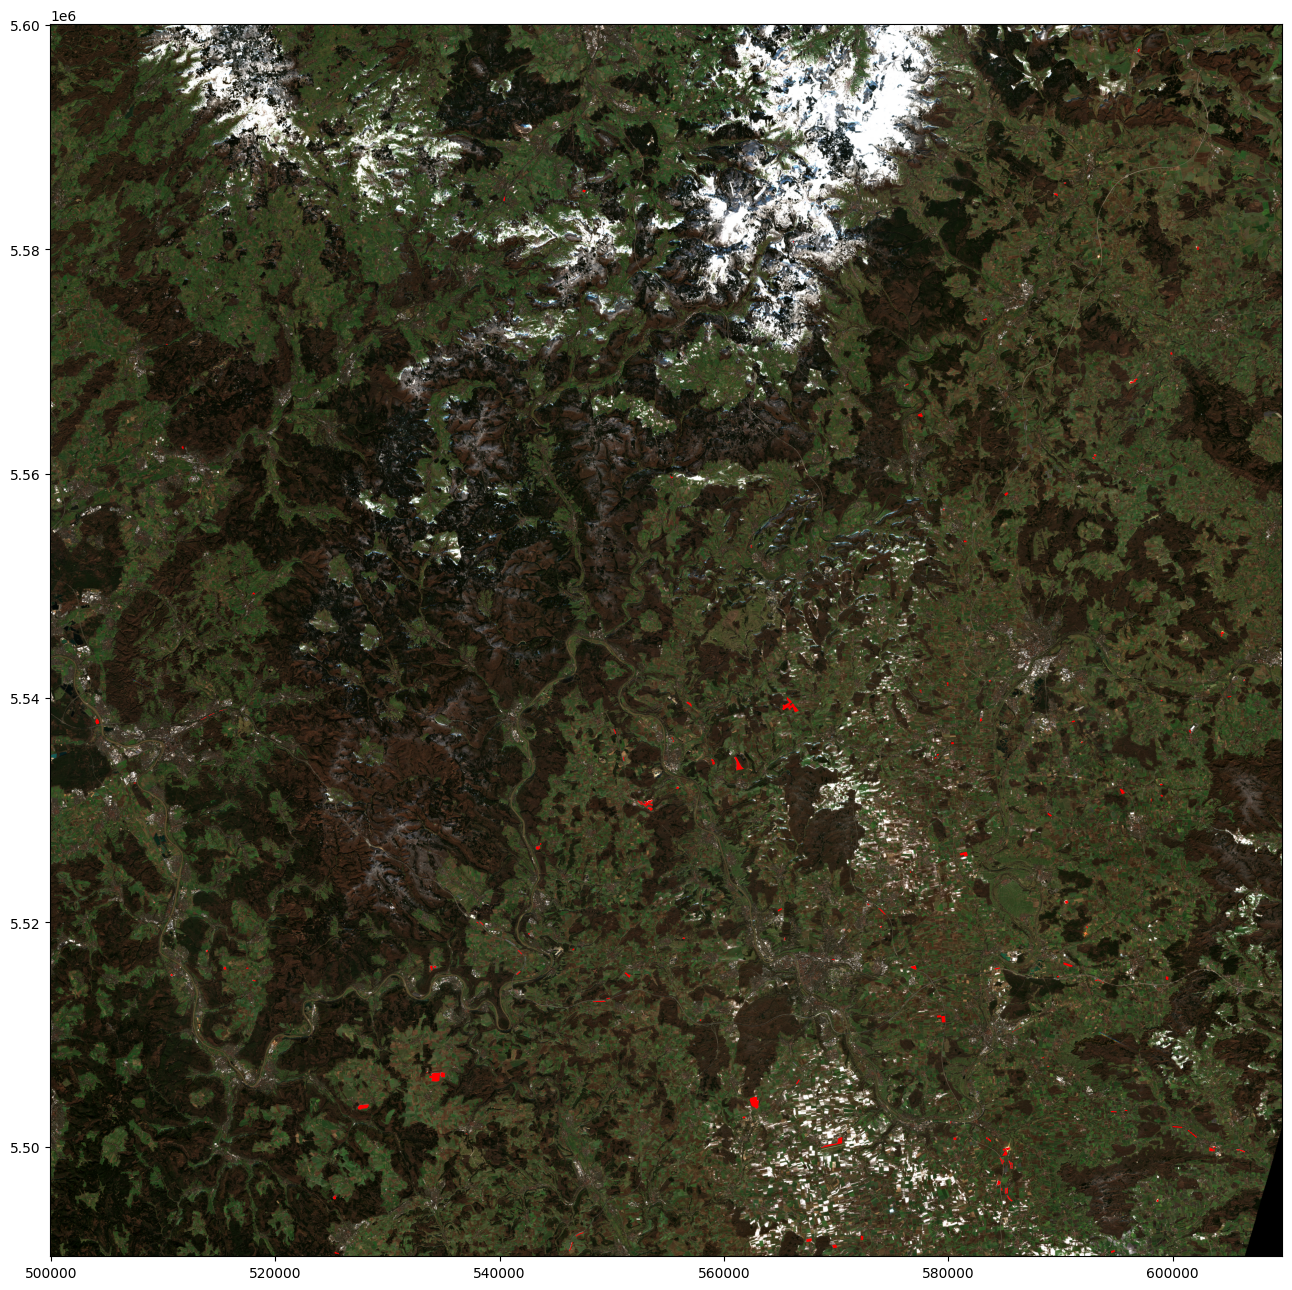

In [8]:
fig, ax = plt.subplots(figsize=(16,16))
show(image, ax=ax)
image_polygons.plot(ax=ax, color='r')
plt.show()

### 2. Convert the polygons to coordinates. (to check if this is working)

In [9]:
example_polygon = image_polygons.iloc[42]
example_polygon.geometry.wkt

'POLYGON ((599968.5553947926 5570202.634671505, 599970.9008460767 5570205.5906147985, 599973.6566080853 5570203.420392567, 599971.3111572994 5570200.464446834, 599968.5553947926 5570202.634671505))'

In [10]:
transformer = Transformer.from_crs(image.crs, "EPSG:4326", always_xy=True)

In [11]:
transformed_polygon = transformer.transform(example_polygon.geometry.exterior.xy[0], example_polygon.geometry.exterior.xy[1])

In [12]:
transformed_polygon

(array('d', [10.402960629334592, 10.402994316157749, 10.403032404725794, 10.40299871790264, 10.402960629334592]),
 array('d', [50.27548569657722, 50.27551187601151, 50.27549189697085, 50.27546571752557, 50.27548569657722]))

In [13]:
lon_lat_polygon = list(zip(*transformed_polygon))
lon_lat_polygon

[(10.402960629334592, 50.27548569657722),
 (10.402994316157749, 50.27551187601151),
 (10.403032404725794, 50.27549189697085),
 (10.40299871790264, 50.27546571752557),
 (10.402960629334592, 50.27548569657722)]

In [14]:
example_polygon.geometry.bounds

(599968.5553947926, 5570200.464446834, 599973.6566080853, 5570205.5906147985)

In [15]:
example_polygon = example_polygon.to_frame()

In [118]:
example_polygon.plot(ax=ax, color='r')

TypeError: no numeric data to plot

TypeError: no numeric data to plot

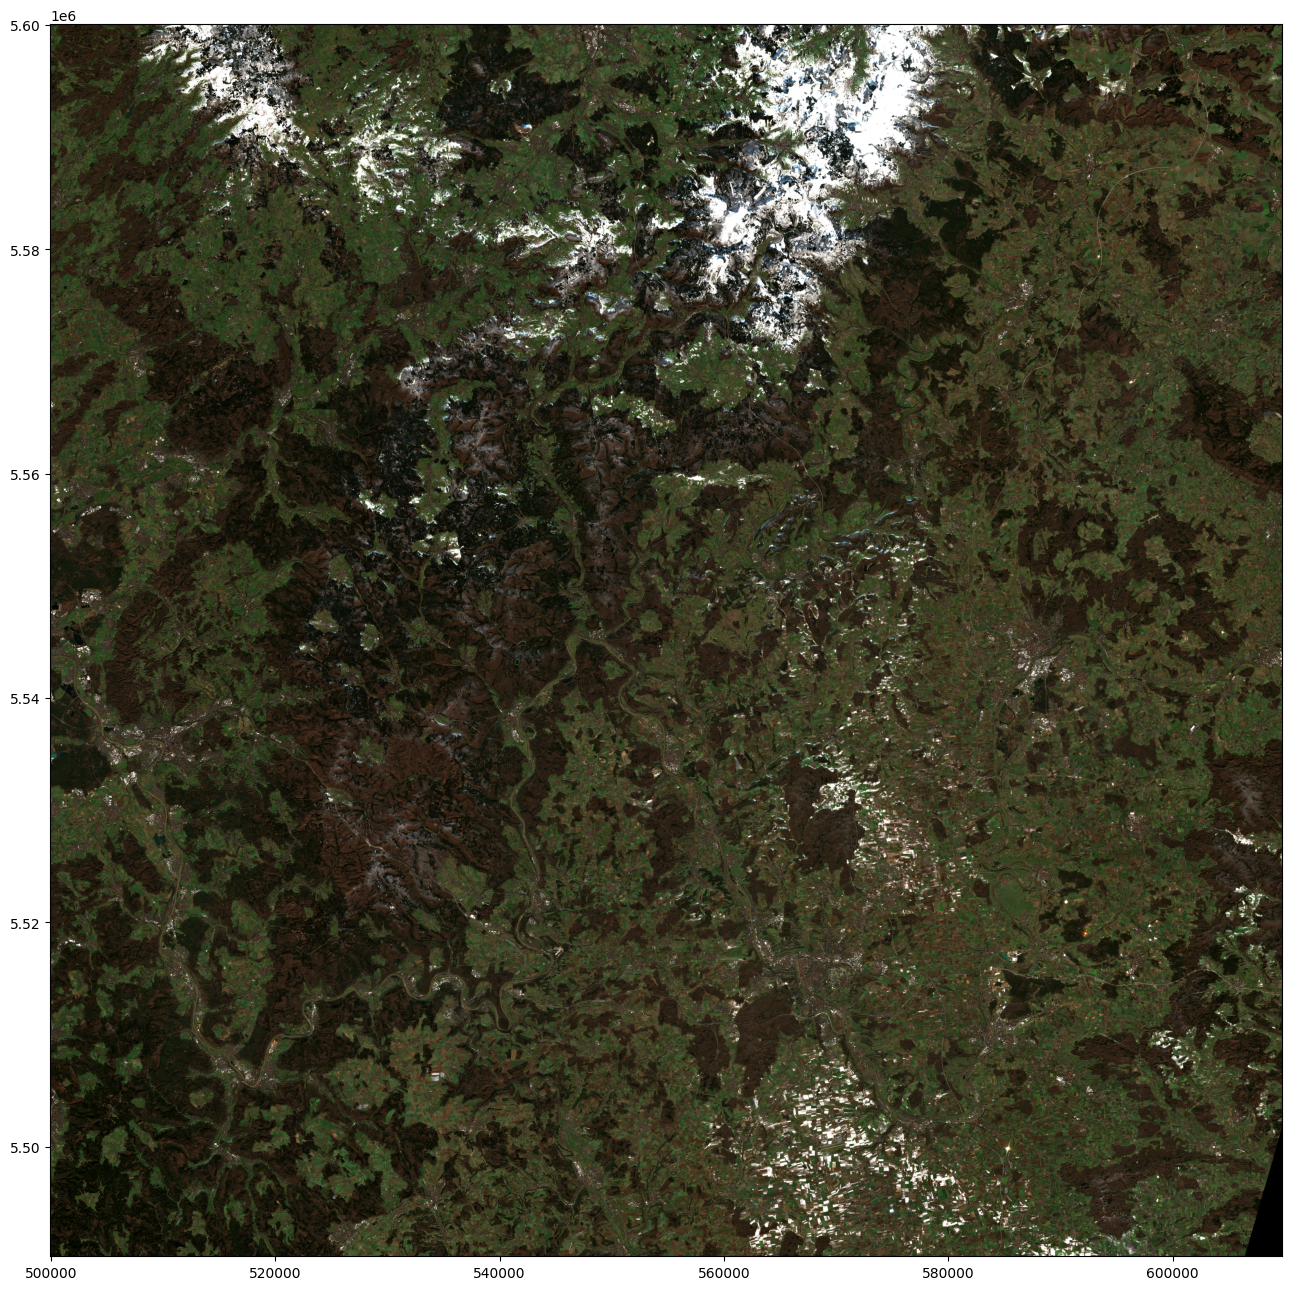

In [115]:
fig, ax = plt.subplots(figsize=(16,16))
show(image, ax=ax)
example_polygon.plot(ax=ax, color='r')
ax.set_xlim(example_polygon.geometry.bounds[0]-500,example_polygon.geometry.bounds[2]+500)
ax.set_ylim(example_polygon.geometry.bounds[1]+500,example_polygon.geometry.bounds[3]-500)
plt.show()

checking:\
https://developers.google.com/maps/documentation/geocoding/overview?hl=de

(swap lat and long to get the right coordinates)

### 3. Cut the large satellite image into smaller images and save them in a folder, but keep the coordinates of the image.

In [16]:
metadata = image.meta
metadata

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32632),
 'transform': Affine(10.0, 0.0, 499980.0,
        0.0, -10.0, 5600040.0)}

In [17]:
small_image_width = 256
small_image_height = 256

In [18]:
# Berechne die Anzahl der Reihen und Spalten für die Aufteilung
num_rows = metadata['height'] // small_image_height
num_cols = metadata['width'] // small_image_width

In [19]:
# Berechne das Padding für die kleinen Bilder
pad_rows = metadata['height'] % small_image_height
pad_cols = metadata['width'] % small_image_width

In [71]:
# Iteriere über die Reihen und Spalten, um das Bild in kleine Bilder aufzuteilen
for row in range(num_rows):
    for col in range(num_cols):
        # Definiere die Fensterkoordinaten für den Ausschnitt
        window = rasterio.windows.Window(col * small_image_width, row * small_image_height,
                                            small_image_width, small_image_height)

        # Lies den Ausschnitt aus dem großen Bild als Numpy-Array
        small_image = image.read(window=window)

        # Aktualisiere die Metadaten für das kleine Bild
        metadata['width'] = small_image_width
        metadata['height'] = small_image_height
        metadata['transform'] = rasterio.windows.transform(window, image.transform)

        # Speichere das kleine Bild als GeoTIFF
        output_dir = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\test_images_geotiff") 
        output_path = output_dir / f'image_{row}_{col}.tiff'
        with rasterio.open(output_path, 'w', **metadata) as dst:
            dst.write(small_image)

In [69]:
import os
os.getcwd()

'c:\\Users\\Fabian\\Documents\\Github_Masterthesis\\Solarpark-detection\\Introduction_Notebooks'

In [72]:
test_path = output_dir / f'image_0_0.tiff'
test_image = rasterio.open(test_path)


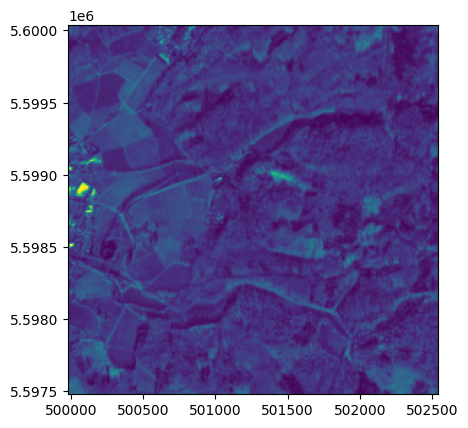

<Axes: >

In [73]:
show(test_image)

### 3. Same as before but the image will be created from the four bands.

In [20]:
FILENAME_REGEX = re.compile(
    r"""(?P<band>B0\d{1})(?:_
    (?P<resolution>\d{2}m))?\..*$""",
    re.VERBOSE,
)

BAND_FILE_MAP = {
    "B02": None,  # blue
    "B03": None,  # green
    "B04": None,  # red
    "B08": None,  # NIR
}

In [21]:
def open_DatasetReaders_as_dict(
    image_dir: str,
) -> Tuple[Dict[str, Any], Union[str, Any]]:
    # fill dict with paths
    for filename in os.listdir(image_dir):
        regex_match = re.match(FILENAME_REGEX, filename)
        if regex_match:
            # ToDo: loop over items in BAND_FILE_MAP instead of keys
            for band_name in BAND_FILE_MAP.keys():
                if filename.endswith(f"{band_name}_10m.jp2"):
                    BAND_FILE_MAP[band_name] = image_dir / filename
                    break

    # Verify that all required bands have been found
    missing_bands = [
        band_name for band_name, file_path in BAND_FILE_MAP.items() if file_path is None
    ]

    if missing_bands:
        raise Exception(f"Missing band files: {missing_bands}")

    # store open DatasetReaders in dict
    return {
        band_name: rasterio.open(file_path)
        for band_name, file_path in BAND_FILE_MAP.items()
    }

In [22]:
image_input_dir = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\training_data_raw\S2A_MSIL2A_20180701T102021_N0208_R065_T32UNA_20180701T141038")
bands = open_DatasetReaders_as_dict(image_input_dir)

blue = np.float32(bands["B02"].read(1))
green = np.float32(bands["B03"].read(1))
red = np.float32(bands["B04"].read(1))
nir = np.float32(bands["B08"].read(1))

In [23]:
# stacked_bands = np.dstack((nir, red, green, blue))
stacked_bands = np.stack([red, green, blue, nir], axis=-1)

In [24]:
metadata = bands["B02"].meta
metadata

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 1,
 'crs': CRS.from_epsg(32632),
 'transform': Affine(10.0, 0.0, 499980.0,
        0.0, -10.0, 5600040.0)}

In [25]:
num_rows = metadata['height'] // small_image_height
num_cols = metadata['width'] // small_image_width

In [ ]:
# Iteriere über die Reihen und Spalten, um das Bild in kleine Bilder aufzuteilen
for row in range(num_rows):
    for col in range(num_cols):
        # Definiere die Fensterkoordinaten für den Ausschnitt
        window = rasterio.windows.Window(col * small_image_width, row * small_image_height,
                                            small_image_width, small_image_height)

        # Schneide den Ausschnitt aus dem zusammengefügten Bild aus
        small_image = stacked_bands[window.row_off:window.row_off + window.height,
                                    window.col_off:window.col_off + window.width, :]

        # Aktualisiere die Metadaten für das kleine Bild
        metadata['width'] = small_image_width
        metadata['height'] = small_image_height
        metadata['transform'] = rasterio.windows.transform(window, bands["B02"].transform)

        # Speichere das kleine Bild als GeoTIFF
        output_dir = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\test_images_geotiff2")
        output_path = output_dir / f'image_{row}_{col}.tif'
        print(small_image.shape)
        with rasterio.open(output_path, 'w', **metadata) as dst:
            dst.write(small_image.transpose(2, 0, 1)[0:2])


In [ ]:
# Iteriere über die Reihen und Spalten, um das Bild in kleine Bilder aufzuteilen
for row in range(num_rows):
    for col in range(num_cols):
        # Definiere die Fensterkoordinaten für den Ausschnitt
        window = rasterio.windows.Window(col * small_image_width, row * small_image_height,
                                            small_image_width, small_image_height)

        # Schneide den Ausschnitt aus dem zusammengefügten Bild aus
        small_image = stacked_bands[window.row_off:window.row_off + window.height,
                                    window.col_off:window.col_off + window.width, :]

        # Aktualisiere die Metadaten für das kleine Bild
        metadata['width'] = small_image_width
        metadata['height'] = small_image_height
        metadata['transform'] = rasterio.windows.transform(window, bands["B02"].transform)

        # Speichere das kleine Bild als GeoTIFF
        output_dir = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\test_images_numpy")
        output_path = output_dir / f'image_{row}_{col}.npy'
        np.save(f'path_to_output_image_{row}_{col}.npy', small_image)

To save the images as numpy arrays costs alot of space.\
1025 KB per patch (1.7GB for the entire image)